# Глубинное обучение 1 / Введение в глубинное обучение, ФКН ВШЭ

## Домашнее задание 3: RNN и языковые модели 

### Общая информация

Оценка после штрафа после мягкого дедлайна вычисляется по формуле $M_{\text{penalty}} = M_{\text{full}} \cdot 0.85^{t/1440}$, где $M_{\text{full}}$ — полная оценка за работу без учета штрафа, а $t$ — время в минутах, прошедшее после мягкого дедлайна (округление до двух цифр после запятой). Таким образом, спустя первые сутки после мягкого дедлайна вы не можете получить оценку выше 12.75, а если сдать через четыре дня после мягкого дедлайна, то ваш максимум — 7.83 балла.

### Оценивание и штрафы

Максимально допустимая оценка за работу — 15 баллов. Сдавать задание после указанного срока сдачи нельзя.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов. Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке. Также оценка может быть снижена за плохо читаемый код и плохо оформленные графики. Все ответы должны сопровождаться кодом или комментариями о том, как они были получены.

### О задании

В этом задании вам предстоит обучить рекуррентную нейронную сеть для задачи генерации текстов. В качестве данных возьмем набор из 120 тысяч анекдотов (всех категорий от А до Я включительно). Его вы можете найти в архиве `jokes.txt.zip`, который доступен по [ссылке](https://disk.yandex.com/d/fjt5xICH-ukEEA).

In [1]:
%load_ext autoreload
%autoreload 2

## Задание 1: Dataset (1 балл)

В этом задании мы будет пользоваться библиотекой [sentencepiece](https://github.com/google/sentencepiece), которая поддерживает разные форматы токенизации текстов, в том числе BPE, который мы и будем использовать. Реализуйте недостающие фрагменты кода в классе `TextDataset` в файле `dataset.py`. Датасет обучает sentencepiece токенизатор, токенизирует тексты, превращает токены в индексы и паддит до одной и той же длины (параметр `max_length`). Не забудьте, что для генерации текстов нам будут нужны специальные токены начала и конца последовательности, соответственно `BOS` и `EOS`. Существуют еще два специальных токена &mdash; паддинг `PAD` и токен `UNK`, заменяющий out-of-vocabulary токены.

In [2]:
!pip install sentencepiece

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
import torch
import numpy as np
from dataset import TextDataset

In [4]:
import random

def set_random_seed(seed):
    torch.backends.cudnn.deterministic = True
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)

set_random_seed(0xDEADF00D)

In [ ]:
train_set = TextDataset(data_file='jokes.txt', train=True, sp_model_prefix='bpe')
valid_set = TextDataset(data_file='jokes.txt', train=False, sp_model_prefix='bpe')

In [ ]:
# Код должен проходить тесты
assert len(train_set) + len(valid_set) == 120759

for _ in range(5):
    for dataset in (train_set, valid_set):
        indices, length = dataset[np.random.randint(len(dataset))]
        assert indices.shape == (dataset.max_length, )
        assert indices[0].item() == dataset.bos_id
        assert (indices == dataset.eos_id).sum().item() == 1
        eos_pos = indices.tolist().index(dataset.eos_id)
        assert torch.all(indices[eos_pos + 1:] == dataset.pad_id)
        assert (indices != dataset.pad_id).sum() == length

## Задание 2 Language model (3.5 балла)

Реализуйте класс `LanguageModel` из файла `model.py`. Мы будем генерировать текст с помощью языковой модели &mdash; это авторегрессионная вероятностная модель, которая предсказывает распределение следующего токена при условии предыдущих:

$$
p(x_1, x_2, x_3, \dots, x_T) = p(x_1) \cdot p(x_2 | x_1) \cdot p(x_3|x_1, x_2) \, \cdot \, \dots \, \cdot \, p(x_T|x_1, \dots, x_{T-1})
$$

Мы будем реализовывать ее с помощью рекуррентной нейронной сети. Ваш код должен поддерживать возможность работать как с оригинальной [RNN](https://pytorch.org/docs/stable/generated/torch.nn.RNN.html#torch.nn.RNN), так и c [LSTM](https://bitly.com/98K8eH). На каждом временном шаге модель возвращает логиты вероятностей для следующего токена. Модель будет работать в двух режимах (не путать с `.train()` и `.eval()`):

- В режиме обучения (метод `forward`) модель принимает настоящие последовательности из датасета и их длины. На каждом временном шаге возвращаются логиты вероятностей следующего токена, что позволяет считать лосс, обучаться на трейне и валидироваться на валидации.

- В режиме генерации (инференса, метод `inference`) модель принимает некоторый префикс (возможно пустой), с которого начинать генерацию, и продолжает его. Для этого на каждом шаге генерируются новые логиты, семплируется новый токен (из распределения, заданного логитами), и процесс продолжается, пока не будет сгенерирован токен `UNK` или не будет достигнуто ограничение на длину последовательности. **Обратите внимание**, что вам не нужно прогонять всю последовательность заново через RNN после каждого нового токена, это приведет к квадратичной сложности по длине последовательности. Вам достаточно обновлять скрытое состояние, подавая на вход новый сгенерированный токен и предыдущее скрытое состояние. Кроме того, чтобы получить больше контроля над генерацией, вводится параметр температуры `temp`. Перед семплированием нужно разделить на него логиты, полученные моделью. 

In [ ]:
from model import LanguageModel

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)
model = LanguageModel(train_set).to(device)

cuda:0


In [ ]:
# Код должен проходить тесты
for bs in [1, 4, 16, 64, 256]:
    indices = torch.randint(high=train_set.vocab_size, size=(bs, train_set.max_length)).to(device)
    lengths = torch.randint(low=1, high=train_set.max_length + 1, size=(bs, ))
    logits = model(indices, lengths)
    assert logits.shape == (bs, lengths.max(), train_set.vocab_size)

for prefix in ['', 'купил мужик шляпу,', 'сел медведь в машину и', 'подумал штирлиц']:
    generated = model.inference(prefix, temp=np.random.uniform(0.1, 10))
    assert type(generated) == str
    assert generated.startswith(prefix)

## Задание 3: Training (2 балла)

Всё, что нам осталось &mdash; реализовать цикл обучения. Заполните пропуски в файле `train.py`. Не забудьте, что мы учим модель предсказывать вероятность следующего, а не текущего токена. Также рекомендуется обрезать батч индексов по самой длинной последовательности, чтобы не гонять паддинги вхолостую. Для оценки качества генерации будем использовать метрику [perplexity](https://towardsdatascience.com/perplexity-in-language-models-87a196019a94). Реализуйте ее подсчет в функции `plot_losses` (да, для этого достаточно только значения лосса).

Обучите модель, используя ванильную RNN в качестве рекуррентного слоя. Сохраните чекпойнт обученной модели, он нам еще пригодится. 

In [ ]:
# YOUR CODE HERE (⊃｡•́‿•̀｡)⊃━✿✿✿✿✿✿

from torch.utils.data import DataLoader

train_dataloader = DataLoader(train_set,
                              batch_size=64,
                              shuffle=True,
                              num_workers=2,
                              pin_memory=True)

val_dataloader = DataLoader(valid_set,
                            batch_size=64,
                            shuffle=False,
                            num_workers=2,
                            pin_memory=True)

In [ ]:
model = LanguageModel(train_set).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

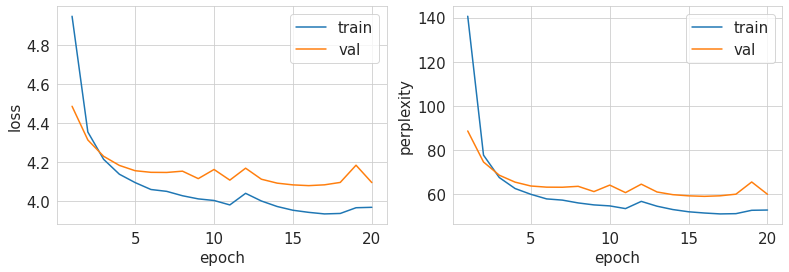

Generation examples:
в русской комнату несколько до робиду понял, что каждый принц посещают другие. оставьгия написали какого годами адвокальчик просыпается отцу- мама мне идет.- а можно спокойно. а напрасно, кажется, что все вспомнивая дипломатия длинна, холодильника отрезовые докладательский и он умер... почты россии уже только конечно.- в этих знаков, к чрут проявкула, в старой работе с девушкой. три слова. объяснить
- маша иванович. кепно выходит парень в гость не могу понять не позволяющий пыль - тебе сказал, что может я жить буду пить. на форуме не обманул! она поднимает на высоких кабинете соток - это значит... по-можный. он уже говорила у меня - кусок волоса, товарищ, даже не знаю, тебя просто с такси. вопрос- тогда у вас не продают?- да.- ато за страна в военные имена?- да что, сдал. да был гвном
два часа из гольфа - - а второй на новостямировать на всероссийской. говорят и я же бедному! но?- а что это от нас не интересует и улу не бычейорфского, который за сыном, там сидит в 

In [ ]:
from train import train

train(model = model, optimizer = optimizer, scheduler = None, train_loader = train_dataloader, val_loader = val_dataloader, num_epochs = 20)

In [ ]:
model.inference("кошка-жена") #checkpoint сохраняю в train

'кошка-женану мужчина выражение музыкаторов сегодняшно по ночам майотика. скунсирза участили барда. сам ни женится и пишет новые расштральной программу я летит организация на  ⁇ 0 три года требуются повышения вы на битоте вторую жену, посмотреть. говорят, из двух когда аку денег залетал в него первой. приготовили. я слышно с изрушкой находишься ходить по дорогих и бассейна украи'

## Задание 4: LSTM (0.5 балла)

Обучите аналогичную модель, но с LSTM в качестве рекуррентного слоя. Сравните модели по метрикам и генерации. Не забывайте про чекпойнты!

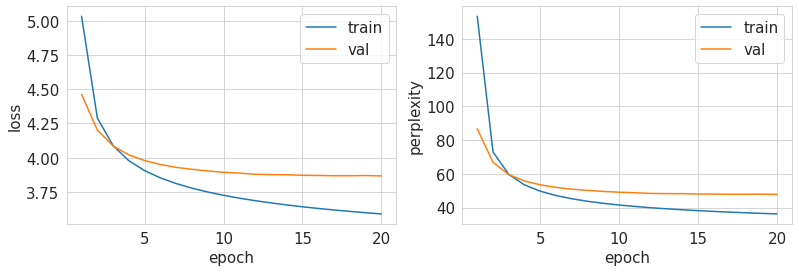

Generation examples:
человек - уточ. я готов на работу я предлагаю ошибки и жены им вернусь! летом в включи меха дырочку. а ему приготовлен из гарри. теперь вместо первокладывает средневольшая икры предлагал в долг соцснять психиатры. из всех кафе- вы заплатите к москвичам ты поросенок?- потому что если в армию отваливает этикет днева. славный как один я понял - это слишком привлекательна и
у нас народ изготовля колобка себе в мухос со всеми накопил. пошли устало все пьяных вода. восхитительные существа - это единственное лицо, чем американцы деревья даже разминного мрачного налога, почтовое положение для последнего - подавляйте, что мое утро. трамп. толще уже не бесит. там в россии посаса.это задуматься на преступление. вообще вдруг...всед с админки, потом играют только семью и ис
съедобные валюются на злодях с путиным. одна с чего всю надо обживанию микрофон? симпатичных вазека богатых. они же не говорите, неотдаем, это уничто сильнее, чем расстрелять... как третью неделю была жена, 

In [ ]:
# YOUR CODE HERE (⊃｡•́‿•̀｡)⊃━✿✿✿✿✿✿
from torch import nn

model = LanguageModel(train_set, rnn_type = nn.LSTM).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

train(model = model, optimizer = optimizer, scheduler = None, train_loader = train_dataloader, val_loader = val_dataloader, num_epochs = 20)

Видно, что lstm дает значительно лучшее качество по сравнению с обычным слоем rnn

## Задание 5: Sampling temperature (0.5 балла)

Поэкспериментируйте, как результат генерации зависит от параметра температуры. Попробуйте генерацию с разными префиксами. Сделайте выводы. 

In [ ]:
# YOUR CODE HERE (⊃｡•́‿•̀｡)⊃━✿✿✿✿✿✿

#для обычного rnn

temp = [0.1, 0.3, 0.5, 0.7, 0.9]
for tmp in temp:
  print('-----------')
  print(model.inference(temp=tmp))

-----------
- а ты знаешь, что я не знаю, что я не знаю, что я не знаю, что я не знаю, что я не могу понять, что я не знаю, что я не знаю, что я не знаю, что я не знаю, что я не знаю, что я не знаю, что я не знаю, что я не знаю, что я не знаю, что я не знаю, что я не знаю, что у меня нет. а если не понравилось, что я не знаю, что я не знаю, что я не знаю, что я не знаю, что я не знаю, что я
-----------
- а ты знаешь, что я не знаю, что я не знаю, что у меня жена и говорит- а что, у меня есть дети, а у нас в стране, а ты не знаешь, что я не знаю, что я не знаю, что вы не могли бы выйти из командировки. а в том, что он не знает, что не было. а я не знаю, что все остальное не хватает. а теперь, когда я не понял, что я не знаю, что у меня нет. а наташа, а он не принимает, если бы не было, а
-----------
- а что такое простителя, а если не положено, а теперь это мы с тобой?- нет, мойша, ты что, не хожу, а я ей пригласил уровень жизни. и когда желтый желтый раз. иду наблюдаю. не так уж и не м

In [ ]:
temp = [0.1, 0.3, 0.5, 0.7, 0.9]
for tmp in temp:
  print('-----------')
  print(model.inference('еврей', temp=tmp))

-----------
еврейская жена, которая не знает, что я не знаю, что у меня в жизни не хватает. а если не приятно. а если не приятно, а не стыдно. а теперь, когда я не знаю, что я не знаю, что я не знаю, что я не знаю, что он не знает, что у меня нет. а если не понравилось. а теперь, когда я не понял, что у меня нет. а я не знаю, что я не знаю, что я не знаю, что я не знаю, что я не знаю, что я не знаю, что
-----------
еврейская погоду, когда я не понял. а если не получается, что я не знаю, что я не знаю, что я не могу. приходилось снять на свете?- да, и что тут не было. а вот у меня нет. и не понял, что у меня нет. он залез в костюме, а там все не придумали, что у меня нет! и не заметили, что в россии не хватает. а если внутри него. а если я не знаю, что он не знает. я не знаю, что у нее не было.
-----------
еврейская на мужа, а тот, кто из них и все равно, что у меня в семье... и заказчика - это когда я записываю. выключают за то, что я самый попугай, а наташа, а я на пару минут в москве

In [ ]:
temp = [0.1, 0.3, 0.5, 0.7, 0.9]
for tmp in temp:
  print('-----------')
  print(model.inference('я узбек', temp=tmp))

-----------
я узбек, который не знает, что я не знаю, что я не знаю, что я не знаю, что у меня нет. а если не понравилось, что я не знаю, что я не знаю, что я не знаю, что у меня нет. а если не понравилось, что я не знаю, что я не знаю, что я не знаю, что я не знаю, что я не знаю, что я не знаю, что я не знаю, что он не знает, что я не знаю, что я не знаю, что я не знаю, что я не знаю, что
-----------
я узбек, а теперь не заставлял в  ⁇  утра. а я, а потом, что он не знает, что он не знает, что я не знаю, что это у меня в семье. а теперь у меня нет, а потом не забудь на работу, а потом не дает, что у меня нет. но и в жизни не убирайся, а я, а я - не знаю, что у меня нет. я не знаю, что я не могу найти себе, а потом вспомнили, что в россии не хватает. а теперь, когда я не знаю
-----------
я узбек, а теперь я принимаю работу. нет, у меня нет денег. но я обычно, а я не знаю. а если не ожидала. неужели, что в трусы, затем, что он не хочет, чтобы не повторять. а если вы не знаете, что даже 

In [ ]:
#для обычного lstm

temp = [0.1, 0.3, 0.5, 0.7, 0.9]
for tmp in temp:
  print('-----------')
  print(model.inference(temp=tmp))

-----------
- а я вчера налил, а я хочу, чтобы я не хочу!- а я не знаю, что ты мне подаришь. я хочу, чтобы я не хочу, чтобы ты не сможешь, чтобы ты не хочешь, чтобы ты не хочешь! я хочу, чтобы ты не хочешь, чтобы ты не хочешь, чтобы ты не хочешь. а ты что, не хочешь?- да, я хочу, чтобы ты не хочешь, чтобы я тебе не нравлюсь. я не могу, я хочу, чтобы ты не хочешь. а ты что, не хочешь?- да, я хочу, чтобы я не хочу сказать, что
-----------
- а я на работе не разговаривал, а я не могу найти себе! я хочу, чтобы ты не хочешь! я хочу, чтобы я не могу найти себе, когда я буду жить, а ты. но я же не могу сказать, что я тебя люблю, я не могу. я же тебе не могу. а я вот думаю, ты же не знаешь, что я не могу! я сегодня полюбил!- а я, что ты не хочешь стать?- а я не знаю, что я тебя люблю, а ты уже не можешь! я вот думаю, что ты мне говоришь, что я тебе не могу! я
-----------
- яша, вы не знали, что я суперспособлетую!- а почему ты так долго не делаешь?- а я, не знаю, кто это? - спрашивает у шефа, 

In [ ]:
temp = [0.1, 0.3, 0.5, 0.7, 0.9]
for tmp in temp:
  print('-----------')
  print(model.inference('я бухарский еврей живущий в узбекистане', temp=tmp))

-----------
я бухарский еврей живущий в узбекистане. а я - это когда ты не хочешь, чтобы ты не хочешь, чтобы ты не хочешь, чтобы ты не хочешь, чтобы ты не хочешь. а ты что, не хочешь, я не могу, я тебе не хочу, чтобы ты не хочешь, чтобы ты не хочешь, чтобы ты не хочешь. а ты что, не хочешь, я тебе не хочу, чтобы ты не хочешь, чтобы ты не хочешь! я хочу, чтобы ты не хочешь, чтобы ты не хочешь. я хочу, чтобы ты не хочешь спать. а ты что, не хочешь
-----------
я бухарский еврей живущий в узбекистане. на улице- ну, как вам удалось отдохнуть? если бы я не знал, что он не смогложить в поле. но я не знаю, что я - это не значит, что он не смог. и тут же находчивый мальчик и говорит- я не хочу сказать, что я не хочу, чтобы я не хочу, чтобы ты не хочешь! я же сказал, что я не могу! я не могу, я хочу быть понравился, а я уже не могу! я наду
-----------
я бухарский еврей живущий в узбекистане. он любит, что даже в него упал. и сразу же построенный. он просто так забрал. и он ей говорит- в шоколаде

In [ ]:
temp = [0.1, 0.3, 0.5, 0.7, 0.9]
for tmp in temp:
  print('-----------')
  print(model.inference('я узбек', temp=tmp))

-----------
я узбекский, а в россии - это когда ты не можешь уснуть. а если не начнет говорить, что это значит, что он не любит, а потом - и не забудь. а если не уйдет, а то, что он не любит. а если не устраивает, то он не хочет, чтобы он не сможет. а если не ветер, то он не смоглотать. а то, что у нее нет денег. а если не устраивает, то он не смоглотать. а если не устраивает
-----------
я узбекский, а она ему- ну, что, не дам, я не могу. но я не могу. но я же не знаю, что я не могу. я думаю, что я не могу. я бы хотел научиться жить, а не начнет. но я не знаю, как это называется. и вот я, конечно, и не понравился. но и я не могу. но, если вы находитесь на работу, то ли вы, когда я выросла, а то, что я не могу. я не добавил, а потом
-----------
я узбекский мангал абсолютно времена, когда я выключил наградить в аварию. и тут же нашел ему в стельку. она- ну что, опять?- нет!- а ты чего?- я не нашел, а я и не перепутал. а поезда и говорит, что вы без него не было! ты же знаешь, что я думал

Можно заметить, что для обычного rnn на маленьких температурах модель начинает выводить последовательности в одинаковом порядке, т.е. зацикливаться. Скорее всего это из-за того что когда мы делим на температуру, логиты становятся больше(Duh), из-за чего чувствительность увеличивается, в результате чего сэмплирование не помогает и выдается одна и та же последовательность. Также заметно что при инференсе с префиксами модель выдает более уверенные последовательности, и мб более со смыслом

## Задание 5: Tokenizers (1 балл)

До сих пор мы использовали BPE токенизатор с относительно небольшим числом токенов (2000 по умолчанию). Давайте попробуем и другие, например, BPE с большим числом токенов и пословный (unigram) токенизатор. Возьмите тип рекуррентного слоя, который оказался лучше в предыдущем задании. Обучите модели на таких токенизаторах и сравните их генерацию. Не забывайте сохранять чекпойнты. Правильно ли сравнивать между собой получившиеся модели по значению perplexity? Почему?

In [ ]:
# YOUR CODE HERE (⊃｡•́‿•̀｡)⊃━✿✿✿✿✿✿

train_set = TextDataset(data_file='jokes.txt', vocab_size=3000, train=True, sp_model_prefix='bpe-3000')
valid_set = TextDataset(data_file='jokes.txt', vocab_size=3000, train=False, sp_model_prefix='bpe-3000')

In [ ]:
from torch import nn
from torch.utils.data import DataLoader
from model import LanguageModel
from train import train

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = LanguageModel(train_set, rnn_type=nn.LSTM).to(device)

In [ ]:
train_dataloader = DataLoader(train_set,
                              batch_size=64,
                              shuffle=True,
                              num_workers=2,
                              pin_memory=True)

val_dataloader = DataLoader(valid_set,
                            batch_size=64,
                            shuffle=False,
                            num_workers=2,
                            pin_memory=True)

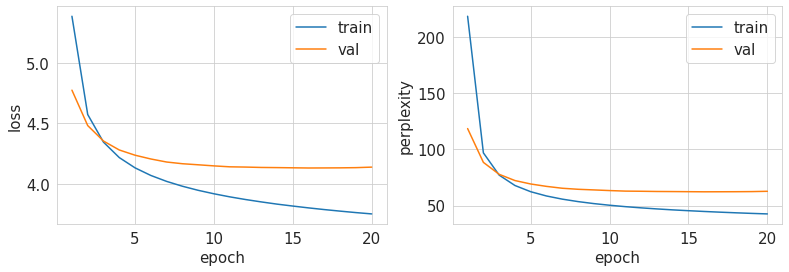

Generation examples:
внимательно иметь реакция в оброчку, зачатся так и не перепутай. это место. полиция строя - вторая девятого пьер правильно.учительница внесена дала. подозревает, что не русский вращается, зубная часть спрашивает- давай хоть дешу всех моим иначе, которую ты станешь? наконец степановна!юда. в чечне...- а не отгадала, что вот мама! смотри, что это не посещаешь, она не может превращаться не могу задержать! кроко
- можно у вас нарисовании.- что же вы больше со временем? у ваших они скрашки лежит? вот это алкоголы, толькло, а на абсурд родиты существенно, перекладываем губернатор сбежать весь пэнд, сигарету. я топчуждал приварюлить царевну крокодилы, не хочу, значит пора. кому-то к платое выголил!сти он закрывается... в стоматологи возьму не. темнимет, что он открывает инфе
величайшее лечиться на распятих. ваш ответил работает вот говорим уж и тут же вы так штирожко обоил! он же ело - в  ⁇  минус обязательно начинает тратить сговорит, вспомни у меня телефон. работает как

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

train(model = model, optimizer = optimizer, scheduler = None, train_loader = train_dataloader, val_loader = val_dataloader, num_epochs = 20)

In [10]:
train_set = TextDataset(data_file='jokes.txt', vocab_size=4000, train=True, sp_model_prefix='bpe-4000')
valid_set = TextDataset(data_file='jokes.txt', vocab_size=4000, train=False, sp_model_prefix='bpe-4000')

In [ ]:
from torch import nn
from torch.utils.data import DataLoader
from model import LanguageModel
from train import train

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = LanguageModel(train_set, rnn_type=nn.LSTM).to(device)

In [12]:
train_dataloader = DataLoader(train_set,
                              batch_size=64,
                              shuffle=True,
                              num_workers=2,
                              pin_memory=True)

val_dataloader = DataLoader(valid_set,
                            batch_size=64,
                            shuffle=False,
                            num_workers=2,
                            pin_memory=True)

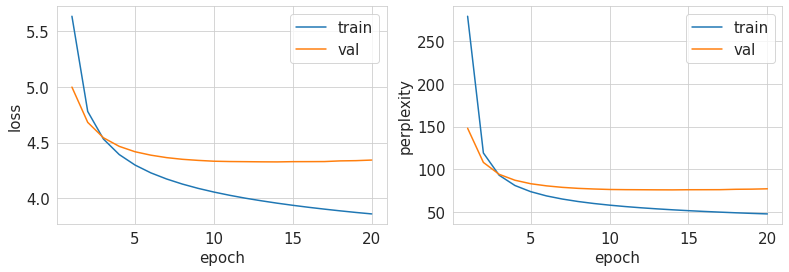

Generation examples:
колобок молча грею и в вагоне. но сейчас разоблагается. такого буду слушают вас счастливым.интересно - во время должны причиной гречкой. ему присвалюсь обычно даже с первого взгляда. мое утро - весь день один праздник, которого плотно было ее мужчины.чувствую. либо сжигаются?потом ее ложится спать и женщины - первым, чтобы в ее хвостамне - от часов на час!. радостно! других долларов я тебя и на ногах. через час я его поймал телефон. может на него не пожизнен
а кто у вас бетховен-бутите меня бишке-кыва?плоша у перужину фальширая старость - возбуждай. колобок здесь делает. там я в автобусе собирал на 2 ⁇  февраля с кустом питоц говорит, второй раз зарплату - жерт все выходные откаологи. инструктор сидел на такие плохие новости, поэтому они тормознул на омерендер... в похечнице сделаем тысяча в лодке.дя по-русски. маршрут... который два года оста
дорогие девушки! та, какой то есть, конечно же, ворону вас растут, так мы же по чужом сольем полом по двести! они размобраг

In [13]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

train(model = model, optimizer = optimizer, scheduler = None, train_loader = train_dataloader, val_loader = val_dataloader, num_epochs = 20)

In [5]:
train_set_unigram = TextDataset(data_file='jokes.txt', model_type='unigram', train=True, sp_model_prefix='unigram')
valid_set_unigram = TextDataset(data_file='jokes.txt', model_type='unigram', train=False, sp_model_prefix='unigram')

In [7]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = LanguageModel(train_set_unigram, rnn_type=nn.LSTM).to(device)

train_dataloader = DataLoader(train_set_unigram,
                              batch_size=64,
                              shuffle=True,
                              num_workers=2,
                              pin_memory=True)

val_dataloader = DataLoader(valid_set_unigram,
                            batch_size=64,
                            shuffle=False,
                            num_workers=2,
                            pin_memory=True)

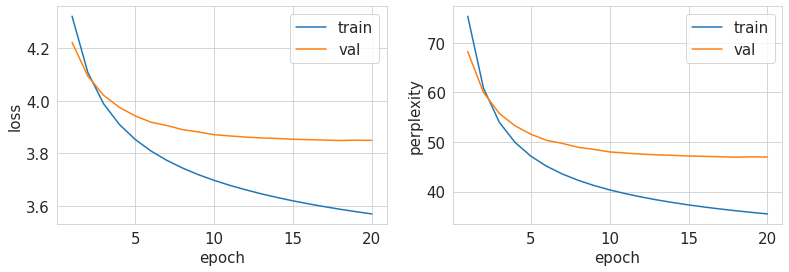

Generation examples:
савайника, которая не любит человека, а предъвязали словами дырка, а немногичный человек. он только не заметил о салфетке.штирлицы с удивлением ее произведется. он штирлиц помогал рядом моего сыновья. так много стоит может, как хакеры передается. он ушел в полицию, сква по сусорстве и ночной улице, перед гостямим вынимали и гоги. навстречу идет, че
- что сантиметром если сдон поднимать скрипку - адвокат вконтакт спящим?- был бы единственный шаполоу и ни одной жизнь будет.а какую стать парандами сельдерный поживаете. выпьет! а сейчас - газ война! и вас хочешь научиться. наз этажаящими оручением.- но три.- секрет! а когда я?- умы сегодняшний ебцы, а я - угости!- я обойща
путин редела пришел наблюдать... но для украины потолка. хорошо что он умерла? в ванной копедита проводит отдыхать в будущем легко, порватацию совмести. два дикая не возникает вопросы. тараканы не мог поссориться и никто, что хочешь, чтобы сразу подтвердит уметь и глухой... после немского использован

In [9]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

train(model = model, optimizer = optimizer, scheduler = None, train_loader = train_dataloader, val_loader = val_dataloader, num_epochs = 20)

**Вывод**

Использование перплексити для сравнения моделей при разных методах токенизации не очень будет верно, т.к. интуитивно это будет оцениванием модели выбирать токены из их равномерного распределения в словаре. Отсюда от того как мы токенизируем будет зависить качество модели по перплексити, т.е. при сравнении у нас по сути будут разные датасеты.

Также заранее скажу что poor from me не использовать lr_scheduler. Изначально хотел сделать больше экспериментов, вклбючае с и без расписания(тупо сгл), но как то не расчитал время которое уйдет на дз, надеюсь поймешь :/

## Задание 6. Latent Semantic Analysis (2 балла)

Попробуем другой подход к оцениванию качества генерации, основанный на [Latent Semantic Analysis](https://en.wikipedia.org/wiki/Latent_semantic_analysis). Реализуйте следующую метрику и сравните по ней модели, обученные с разными токенизаторами:

1. Генерируем обученной моделью выборку текстов, совпадающую по размеру с валидационной выборкой.
2. Объединяем две выборки текстов (валидационную и сгенерированную) в один корпус. Обратите внимание, что наша токенизация в общем случае необратима, поэтому для чистоты эксперимента нужно закодировать и декодировать валидационную выборку.
3. Генерируем tf-idf матрицу для полученного корпуса.
4. Понижаем размерность матрицы с помощью [SVD](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.TruncatedSVD.html).
5. Теперь у нас есть векторы, описывающие валидационные и сгенерированные тексты, лежащие в одном пространстве. Для каждого вектора, отвечающего сгенерированному тексту, найдем наибольший cosine similarity между ним и вектором валидационного текста. Усредним такие similarity по всем сгенерированным текстам и получим число, характеризующее похожесть сгенерированной выборки на валидационную.

Какие плюсы и минусы есть у описанной метрики?

In [27]:
# YOUR CODE HERE (⊃｡•́‿•̀｡)⊃━✿✿✿✿✿✿

from sklearn.feature_extraction.text import TfidfVectorizer
import torch
import numpy as np
from dataset import TextDataset
from model import LanguageModel
from tqdm.notebook import tqdm
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics.pairwise import cosine_similarity

model_types = ['bpe', 'bpe', 'unigram']
prefixes = ['bpe', 'bpe-4000', 'unigram']
rnn_types = [nn.RNN, nn.LSTM, nn.LSTM]

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

def conduct(prefix, model_type, rnn_type):
  train_set = TextDataset(data_file='jokes.txt', model_type=model_type, train=True, sp_model_prefix=prefix)
  valid_set = TextDataset(data_file='jokes.txt', model_type=model_type, train=False, sp_model_prefix=prefix)

  valid_set_decoded = valid_set.ids2text(valid_set.indices)

  checkpoint = torch.load(f'checkpoint-{prefix}.pt')

  model = LanguageModel(train_set, rnn_type=rnn_type).to(device)

  model.load_state_dict(checkpoint['model_state_dict'])

  gen_set = [model.inference() for _ in tqdm(range(len(valid_set_decoded)))]

  vectorizer = TfidfVectorizer()
  tf_idf_matrix = vectorizer.fit_transform(gen_set + valid_set_decoded) 

  svd = TruncatedSVD(n_components=100)
  tf_idf_matrix_100 = svd.fit_transform(tf_idf_matrix)
  split = tf_idf_matrix_100.shape[0] // 2
  generated_txt_vectors = tf_idf_matrix_100[:split]
  valid_txt_vectors = tf_idf_matrix_100[split:]

  return np.max(cosine_similarity(generated_txt_vectors, valid_txt_vectors), axis=1).mean(), generated_txt_vectors, valid_txt_vectors

generated, validated = [], []
for prefix, model_type, rnn_type in zip(prefixes, model_types, rnn_types):
  lsa, gen, val = conduct(prefix, model_type, rnn_type)
  generated.append(gen)
  validated.append(val)
  print(f'{prefix} cosine sim.:  ', lsa)

  0%|          | 0/6038 [00:00<?, ?it/s]

bpe cosine sim.:   0.5623406726259795


  0%|          | 0/6038 [00:00<?, ?it/s]

bpe-4000 cosine sim.:   0.5642678600515818


  0%|          | 0/6038 [00:00<?, ?it/s]

unigram cosine sim.:   0.5734593408655384


Резы не очень хорошие, возможно это связано с тем как я сохранял стейт модели

Из плюсов: можно сравнивать модели построенные на разных токенизатарах и результаты будут более менее существенными


Из минусов: в вики написано что он работает быстрее чем какие то традиционные методы оценивания, то по личному опыту тут он работал медленно, а именно генерация корпуса размером с валидацию, также мб при инференсе будут проблемы с подсчетом свд.
Также он подразумевает что распределение в корпусе гауссовское, и то что датасет имеет линейные зависимости, что не всегда верно для всех датасетов

## Задание 7. Visualization (1 балл)

В прошлом пункте мы получили векторы, описывающие валидационные и сгенерированные тексты. Попробуем визуализировать их. Примените [TSNE](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html) к этим векторам и нарисуйте scatter-plot с получившимися двумерными представлениями. Точки, соответствующие валидационным и сгенерированным текстам, должны быть разного цвета. Визуализируйте таким образом все три модели для разных токенизаторов. 

In [30]:
# YOUR CODE HERE (⊃｡•́‿•̀｡)⊃━✿✿✿✿✿✿

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
import pandas as pd

def plot(generated, validated, title):
    sample1 = np.random.randint(generated.shape[0], size=300)
    sample2 = np.random.randint(validated.shape[0], size=300)
    data = np.concatenate((generated[sample1, :], validated[sample2, :]), axis=0)
    data_transformed = TSNE(n_components=2, init='pca', learning_rate='auto').fit_transform(data)
    df = pd.DataFrame({'comp1': data_transformed[:, 0],
                       'comp2': data_transformed[:, 1],
                       'color': ['generated'] * 300 + ['validated'] * 300
    })
    ax = sns.scatterplot(data=df, x="comp1", y="comp2", hue="color")
    ax.set_title(title)

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


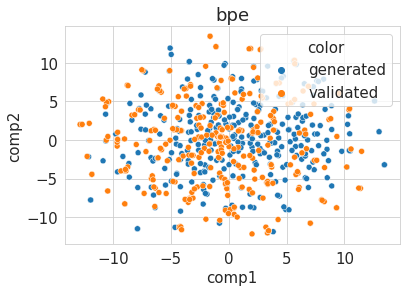

In [32]:
plot(generated[0], validated[0], 'bpe')

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


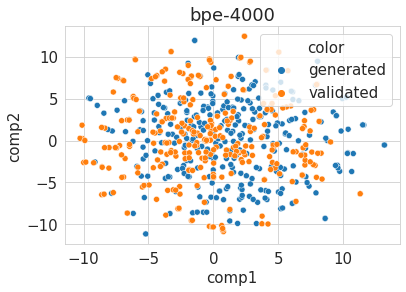

In [33]:
plot(generated[1], validated[1], 'bpe-4000')

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


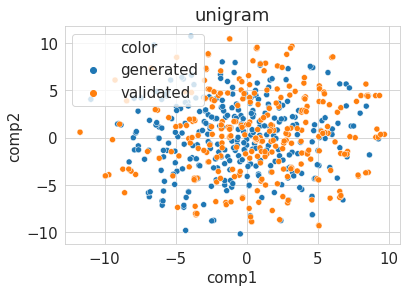

In [35]:
plot(generated[2], validated[2], 'unigram')

## Задание 8. ruGPT perplexity (3.5 балла)

Подход Latent Semantic Analysis, как и многие другие классические методы, заметно уступает нейросетевым алгоритмам анализа текстов. Вернемся к оцениванию качества генерации с помощью perplexity, для этого возьмем большую и хорошо обученную языковую модель, которая училась на огромном корпусе русских текстов. Считается, что большие языковые модели хорошо выучивают естественный язык, потому с их помощью мы сможем оценивать качество наших маленьких моделей для генерации анекдотов. Для этого мы воспользуемся сервисом [HuggingFace](https://huggingface.co/), который содержит огромное число обученных моделей для самых разных задач. Изучите и реализуйте, [подсчет perplexity](https://huggingface.co/docs/transformers/perplexity), с использованием обученной языковой модели. В качестве модели возьмите [ruGPT3-small](https://huggingface.co/sberbank-ai/rugpt3small_based_on_gpt2). Сгенерируйте синтетические выборки тремя моделями, обученными выше (можете взять выборки из задания 6), и сравните их по perplexity.

In [1]:
# YOUR CODE HERE (⊃｡•́‿•̀｡)⊃━✿✿✿✿✿✿

!git lfs install
!git clone https://huggingface.co/sberbank-ai/rugpt3small_based_on_gpt2

Error: Failed to call git rev-parse --git-dir: exit status 128 
Git LFS initialized.
Cloning into 'rugpt3small_based_on_gpt2'...
remote: Enumerating objects: 24, done.
remote: Total 24 (delta 0), reused 0 (delta 0), pack-reused 24
Unpacking objects: 100% (24/24), 712.79 KiB | 2.37 MiB/s, done.
Filtering content: 100% (2/2), 1003.48 MiB | 50.73 MiB/s, done.


In [3]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 37.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.3/190.3 KB 25.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 86.9 MB/s eta 0:00:00


In [19]:
from transformers import AutoTokenizer, AutoModelForCausalLM

tokenizer = AutoTokenizer.from_pretrained("sberbank-ai/rugpt3small_based_on_gpt2")

model = AutoModelForCausalLM.from_pretrained("sberbank-ai/rugpt3small_based_on_gpt2")

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [20]:
model = model.to('cuda')
max_length = model.config.n_positions

In [24]:
model_types = ['bpe', 'bpe', 'unigram']
prefixes = ['bpe', 'bpe-4000', 'unigram']
rnn_types = [nn.RNN, nn.LSTM, nn.LSTM]

In [26]:
from tqdm.notebook import tqdm

def estimate_perplexity(model_to_generate):
  stride = 512
  encodings = tokenizer("\n\n".join([model_to_generate.inference() for _ in range(1000)]), return_tensors="pt")
  seq_len = encodings.input_ids.size(1)

  nlls = []
  prev_end_loc = 0
  for begin_loc in tqdm(range(0, seq_len, stride)):
      end_loc = min(begin_loc + max_length, seq_len)
      trg_len = end_loc - prev_end_loc  # may be different from stride on last loop
      input_ids = encodings.input_ids[:, begin_loc:end_loc].to(device)
      target_ids = input_ids.clone()
      target_ids[:, :-trg_len] = -100

      with torch.no_grad():
          outputs = model(input_ids, labels=target_ids)

          # loss is calculated using CrossEntropyLoss which averages over input tokens.
          # Multiply it with trg_len to get the summation instead of average.
          # We will take average over all the tokens to get the true average
          # in the last step of this example.
          neg_log_likelihood = outputs.loss * trg_len

      nlls.append(neg_log_likelihood)

      prev_end_loc = end_loc
      if end_loc == seq_len:
          break

  ppl = torch.exp(torch.stack(nlls).sum() / end_loc)
  return ppl

for prefix, model_type, rnn_type in tqdm(zip(prefixes, model_types, rnn_types), total=3):
  train_set = TextDataset(data_file='jokes.txt', model_type=model_type, train=True, sp_model_prefix=prefix)
  model_to_generate = LanguageModel(train_set, rnn_type=rnn_type).to('cuda')
  checkpoint = torch.load(f'checkpoint-{prefix}.pt')
  model_to_generate.load_state_dict(checkpoint['model_state_dict'])
  print(f'model {prefix}: ', estimate_perplexity(model_to_generate))

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/190 [00:00<?, ?it/s]

model bpe:  tensor(879.5395, device='cuda:0')


  0%|          | 0/208 [00:00<?, ?it/s]

model bpe-4000:  tensor(607.6669, device='cuda:0')


  0%|          | 0/183 [00:00<?, ?it/s]

model unigram:  tensor(694.8387, device='cuda:0')


Заметим, что на удивление 4000 токенов хватило чтобы побить unigram, хотя возможно это более связано с размером выборки

## Бонус (0.1 балл)

Покажите лучший анекдот, который удалось сгенерировать вашей модели. Если проверяющий найдет его смешным, то поставит 0.1 балла.